#### Oppsett - kjør dette først!

In [1]:
import cv2
import glob
import spacy
import requests
import mimetypes

from asrtoolkit import cer, wer

from collections import Counter
from wordcloud import WordCloud

from doc_ufcn import models
from doc_ufcn.main import DocUFCN

from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
img_path = 'db60044923000260.jpg'

In [4]:
fasit = open('db60044923000260_fasit.txt').read()

In [5]:
print(fasit)

nabostats territorium, slik at det internasjonale organ
ved lov gis myndighet endog innen det norske rikes grenser.

Jeg antar at man ved tolkinger av Grl.'s § 1 ikke
kommer utenom en viss inflytelse av de tradisjonelle folke-
rettslige suverenitetsforestillinger og de historisk-
tradisjonelle inndelinger av statenes innbyrdes forhold i
statsrettslige og folkerettsligeforbindelser alt etter
hvilket formelt gyldighetsgrunnlag de har. Det er nemlig
åpenbart at grunnloven må forutsette en vidtgående adgang
for Norge til å påta seg folkerettslige forpliktelser som
nödvendigvis må begrense landets handlefrihet. Og når det
gjelder forpliktelser og forbindelser som tradisjonelt har
vært ansett som folkerettslige ( og fölgelig formelt -
begrepsmessig - suverenitetsbevarende i folkerettslig
forstand) er det naturlig å anta at grunnloven tillater
större innskrenkning av handlefrihetan enn når det gjelder
forpliktelser og forbindelser som tradisjonelt har vært
r1eknet for å være av statsrettslig 

In [6]:
auth_token = '266575f8-aad9-457e-8cbf-f1d7223c2a51'

In [7]:
from pathlib import Path
def download_urnid_from_da(urnid: str, destination_directory: str, auth_token: str):
    """
    Download the requested urnid to a specified directory
    Args:
        urnid (str): 16-character urnid
        destination_directory (str): path to directory to download image to
        auth_token (str): DA token to use for downloading
    """
    API_IMAGE_DOWNLOAD = 'https://media.digitalarkivet.no/api/v1/image/{}'
    response = requests.get(f'{API_IMAGE_DOWNLOAD.format(urnid)}.jpg', headers={'auth-token': auth_token})
    extension = mimetypes.guess_extension(response.headers['Content-Type'].split(';')[0])
    destination_directory = Path(destination_directory)
    destination_directory.mkdir(exist_ok=True)
    output_file_path = (destination_directory / urnid).with_suffix(extension)
    with open(output_file_path, 'wb') as f:
        f.write(response.content)
    return str(output_file_path)

### Del 1:
Definer funksjonen `ocr_file`:

In [8]:
#https://stackoverflow.com/questions/46335488/how-to-efficiently-find-the-bounding-box-of-a-collection-of-points
def bounding_box(points):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    Here, we traverse the collection of points only once, 
    to find the min and max for x and y
    """
    bot_left_x, bot_left_y = float('inf'), float('inf')
    top_right_x, top_right_y = float('-inf'), float('-inf')
    for x, y in points:
        bot_left_x = min(bot_left_x, x)
        bot_left_y = min(bot_left_y, y)
        top_right_x = max(top_right_x, x)
        top_right_y = max(top_right_y, y)

    return [(bot_left_x, bot_left_y), (top_right_x, top_right_y)]

In [9]:
def ocr_file(img_path: str) -> str:
    
    transcript = ''
    
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    model_path, parameters = models.download_model('generic-historical-line')
    model = DocUFCN(len(parameters['classes']), parameters['input_size'], 'cuda')
    model.load(model_path, parameters['mean'], parameters['std'])
    detected_polygons, probabilities, mask, overlap = model.predict(image, raw_output=False, mask_output=False, overlap_output=False)
    
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
    ocr = VisionEncoderDecoderModel.from_pretrained("models/trocr/checkpoint-9000/")
    
    for polygon in detected_polygons[1]:
        bb = bounding_box(polygon['polygon'])
        img = image[bb[0][1]:bb[1][1], bb[0][0]:bb[1][0]]

        pixel_values = processor(img, return_tensors="pt").pixel_values
        generated_ids = ocr.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        transcript += generated_text+'\n'
        
    
    return transcript.strip()

Kjør disse cellene for å evaluere:

In [10]:
%%time
ocr_result = ocr_file(img_path)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/mnt/md1/avai_kasus/env/lib/python3.8/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


CPU times: user 1h 13min 30s, sys: 1min 24s, total: 1h 14min 55s
Wall time: 4min 1s


In [11]:
print(ocr_result)

rebostats terrorium, slik at det internasjonale organ
ved lov gis myndighet endog innen det norske rikes grenser.
Jeg antar at man ved folkinger av Grl.'s § 1 ikke
kommer utenom en viss innlytelse av de tradisjonelle folke-
rettslige suverenitetsforestillinger og de historisk-
tredisjonelle inndelinger av statenes innbyrdes forhold i
statsrettslige og folkerettsligg forbindelser alt etter
hvikket formelt gyldighetsgrunnlag de har. Det er nemlig
åeenbart at grunnloven må forutsette en vidtgående adgang
for Norge til å påta seg forkerettslige forpliktelser som
nödvendigvis må begrense landets handlefrihet. Og vår det
gjelder forpliktelser og forbindelser som tradisjonelt har
vært ansatt som folkerettslige ( og fölgelig formallte -
begreppsmessig - Suverenitetsbevars i folkerettslig
forstand) er det naturlig å enta at grunnloven tillater
större innskrenktinget handlefriheten enn når det gjelder
føknet for ør annsen statsrstelsertsenigestierti-gefhelt har vært
Disse tradisjonelle somdringe

In [12]:
print(f'character error rate: {cer(fasit, ocr_result)}\nword error rate: {wer(fasit, ocr_result)}')

character error rate: 16.599655370476736
word error rate: 31.417624521072796


### Del 2
Filen 127588_urnids.txt er en liste over urnid-er, eller pekere til bildefiler. Disse kan brukes opp mot API-et til Digitalarkivet for å hente ut bilder med funksjonen `download_urnid_from_da`, som du har fått i starten. Funksjonen tar inn en urnid og returnerer banen som bildet er lastet ned til.

In [13]:
urnids = open('./127588_urnids.txt').read().split('\n')

In [14]:
# laster ned alle bildene lokalt
#for urnid in urnids:
#    download_urnid_from_da(urnid, './imgs', auth_token)

In [15]:
download_path_for_image_number_10 = download_urnid_from_da(urnids[10], './images', auth_token)
print(download_path_for_image_number_10)

images/db60044923000011.jpg


Bruk denne listen sammen med `download_urnid_from_da`, som du fikk, og `ocr_file`, som du har definert, til å lage et korpus over alle dokumentene i denne kilden. Kjør noe NLP på dette som du mener kan være interessant.

In [16]:
# kjører en egen ocr-prosess med skriptet skriptet 'ocr_as_much_as_possible.py'. ting tar tid ...
nlp = spacy.load("models/spacy/model-best/", disable=["trainable_lemmatizer","parser","ner"])

/mnt/md1/avai_kasus/env/lib/python3.8/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'nb_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


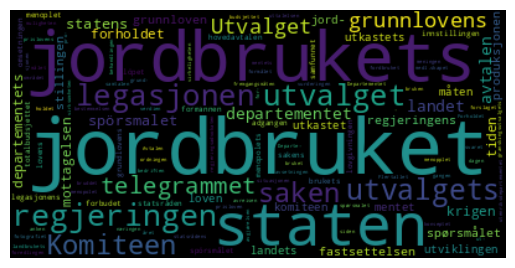

In [17]:
pages = glob.glob("transcripts/*.txt")
discourse_ents = []

for page in pages:
    with open(page, 'r') as data:
        for tok in nlp(data.read()):
            try:
                pos = tok.pos_
                feats = tok.morph.to_dict()
                if pos == "NOUN" and feats["Definite"] == "Def" and feats["Number"] == "Sing":
                    discourse_ents.append(tok.text)
            except KeyError:
                continue
                
counts = Counter(discourse_ents)
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=counts)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()